In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sporco.dictlrn import dictlrn
from sporco.admm import cbpdn,ccmod
from sporco import cnvrep
from pytictoc import TicToc
import matplotlib.gridspec as gridspec
import pickle
from sporco.admm import cbpdn
from misc import processing

In [2]:
# Init filename and address
file_name = ['ear']
short_axis_length = 20
# Module level constants
eps = 1e-14
lmbda = 1e-1
i = 0

In [3]:
# Load the example dataset
s, D = processing.load_data(file_name[0], decimation_factor=short_axis_length)

rvmin, vmax = 5, 55 #dB


s_log = 20 * np.log10(abs(s))

# l2 norm data and save the scaling factor
l2f, snorm = processing.to_l2_normed(s)
K = snorm.shape[1]  # number of A-line signal
N = snorm.shape[0]  # length of A-line signgal
M = 1  # state of dictionary
print("file name", file_name)

print("number of A-line signal", K)
print("length of A-line signgal", N)
opt_par = cbpdn.ConvBPDN.Options({'FastSolve': True, 'Verbose': False, 'StatusHeader': False,
                                  'MaxMainIter': 200, 'RelStopTol': 5e-5, 'AuxVarObj': True,
                                  'RelaxParam': 1.515, 'AutoRho': {'Enabled': True}})

# Weigth factor to apply to the fidelity (l2) term in the cost function
# in regions segmented as containing speckle
speckle_weight = 0.1
lmbda = 0.05
w_lmbda = 0.05

b0 = cbpdn.ConvBPDN(D, snorm, lmbda, opt=opt_par, dimK=1, dimN=1)
x0norm = b0.solve().squeeze() + eps
r0norm = b0.reconstruct().squeeze()

x0norm = np.roll(x0norm, np.argmax(D), axis=0)
x0 = processing.from_l2_normed(x0norm, l2f)
r0 = processing.from_l2_normed(r0norm, l2f)

x0_log = 20 * np.log10(abs(x0))
r0_log = 20 * np.log10(abs(r0))

# update opt to include W
x1, W = processing.make_sparse_representation(s, D, lmbda,w_lmbda, speckle_weight, Mask=True, Ear=True)
x1_log = 20 * np.log10(abs(x1))

(330, 10240)
file name ['ear']
number of A-line signal 512
length of A-line signgal 330


In [11]:
print(np.shape(W))
print(np.max(W))

(330, 512)
1.0


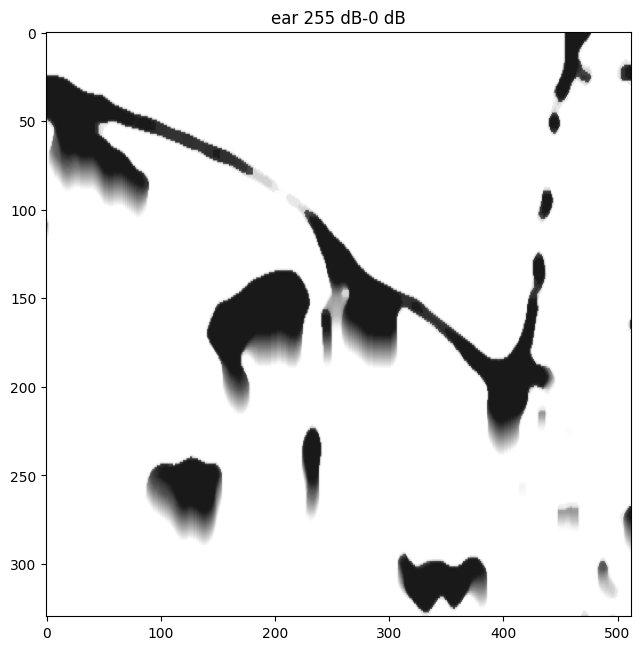

In [12]:
fig = plt.figure(figsize=(18, 13), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)
ax = fig.add_subplot(gs[1, 0])


vmin, vmax = 0,255
ax.set_title(file_name[i]+' %d dB-%d dB' % (vmax, vmin))
ax.imshow(255*W, cmap='gray', vmax=vmax, vmin=vmin)
ax.set_aspect(x1_log.shape[1] / x1_log.shape[0])
#
# ax = fig.add_subplot(gs[1, 1])
# ax.set_title('selected A-line')
# ax.plot(abs(D))
# ax.set_ylabel('magnitude(a.u.)')
# ax.set_xlabel('axial depth(pixels)')

# ax = fig.add_subplot(gs[1, 2])
# ax.set_title('estimated PSF')
# ax.plot(abs(D1))
# ax.set_ylabel('magnitude(a.u.)')
# ax.set_xlabel('axial depth(pixels)')

plt.show()

In [5]:
import cv2
from skimage.transform import resize


In [6]:
# Compute the minimum and maximum values of the array
image_array =x1_log
image_array[image_array < 0] = 0
min_value = np.min(image_array)
max_value = np.max(image_array)
print(max_value)
print(min_value)

# Normalize the array and scale it to the range [0, 255]
normalized_array = (image_array - min_value) / (max_value - min_value) * 255

# Convert the normalized array to uint8 data type
uint8_array = normalized_array.astype('uint8')

51.78608137217594
0.0


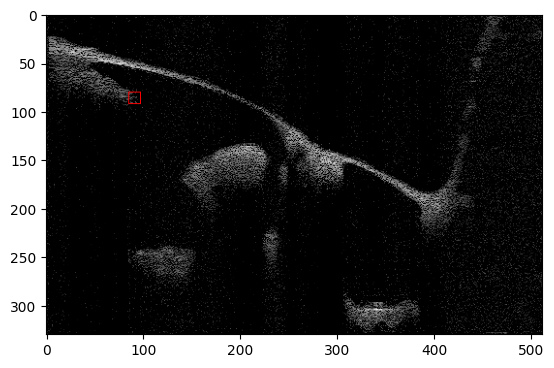

In [7]:
drawImg = cv2.cvtColor(np.array(uint8_array), cv2.COLOR_GRAY2BGR)
startX = 80
startY = 85
# Draw a rectangle on the image
cv2.rectangle(drawImg, (startY, startX), (startY + 12, startX + 12), (255, 0, 0), 1)
partial_img = drawImg[startX:startX+17, startY:startY+17]
partial_img = resize(partial_img,(64,64))
# Display the image with the rectangle
plt.imshow(drawImg)
plt.show()